In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Path to the dataset
dataset_path = r"C:\Dataset\Herlev\Herlev Dataset\Processed_Dataset"
batch_size = 32
num_classes = 7  # Number of classes (7 directories)
num_epochs = 20  # Training epochs
learning_rate = 0.001

# Step 1: Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for SqueezeNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the entire dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Split into train and validation sets (80%, 20%)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # For validation

In [2]:
import torch
import torch.nn as nn
from torchvision import models

class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.model = models.resnet50(pretrained=True)  # You can choose resnet18, resnet34, etc.
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Replace final FC layer
        self.model.num_classes = num_classes

    def forward(self, x):
        return self.model(x)

# Instantiate model, optimizer, and loss function
num_classes = 7  # Replace with your number of classes
model = CustomResNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [3]:
# Step 3: Combine Lévy Flight and Brownian Motion
def levy_brownian_step(prob_brownian=0.3, lam=1.5, size=1):
    """
    Generate a step that combines Lévy flight and Brownian motion based on a given probability.
    """
    if np.random.rand() < prob_brownian:
        # Brownian motion: Small, incremental steps
        sigma_brownian = 0.1
        return np.random.normal(0, sigma_brownian, size)
    else:
        # Lévy flight: Long jumps based on Lévy distribution
        sigma_levy = (np.math.gamma(1 + lam) * np.sin(np.pi * lam / 2) /
                      (np.math.gamma((1 + lam) / 2) * lam * 2 ** ((lam - 1) / 2))) ** (1 / lam)
        u = np.random.normal(0, sigma_levy, size)
        v = np.random.normal(0, 1, size)
        return u / (np.abs(v) ** (1 / lam))
# Step 4: Implement Gazelle Optimizer with Lévy and Brownian
class GazelleOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, momentum=0.9, exploration_factor=0.1, num_gazelles=10, prob_brownian=0.3):
        defaults = dict(lr=lr, momentum=momentum, exploration_factor=exploration_factor, num_gazelles=num_gazelles)
        super(GazelleOptimizer, self).__init__(params, defaults)

        self.num_gazelles = num_gazelles
        self.gazelles = None
        self.prob_brownian = prob_brownian

    def initialize_population(self, param_shape):
        lb = -1.0
        ub = 1.0
        self.gazelles = torch.empty((self.num_gazelles, *param_shape), 
                                device='cuda' if torch.cuda.is_available() else 'cpu')
        self.gazelles.uniform_(lb, ub)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            momentum = group['momentum']
            lr = group['lr']
            exploration_factor = group['exploration_factor']
            num_gazelles = group['num_gazelles']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                if self.gazelles is None or self.gazelles.shape[1:] != d_p.shape:
                    self.initialize_population(d_p.shape)

                # Exploration phase using combined Lévy flight and Brownian motion
                levy_brownian_step_vector = torch.tensor(
                    levy_brownian_step(prob_brownian=self.prob_brownian, size=d_p.numel()),
                    device=p.device,
                    dtype=p.dtype
                ).view_as(d_p)

                for i in range(num_gazelles):
                    self.gazelles[i] = (self.gazelles[i] + levy_brownian_step_vector * exploration_factor).clamp_(-1.0, 1.0)

                # Apply momentum and update
                if 'momentum_buffer' not in self.state[p]:
                    self.state[p]['momentum_buffer'] = torch.clone(d_p).detach()
                else:
                    buf = self.state[p]['momentum_buffer']
                    buf.mul_(momentum).add_(d_p)
                    d_p = buf

                # Update parameters with exploration and elite adjustment
                elite_gazelle = self.gazelles.mean(dim=0)
                p.data.add_(-lr, d_p + exploration_factor * elite_gazelle)

        return loss

In [4]:
# Step 5: Instantiate Optimizer
optimizer = GazelleOptimizer(model.parameters(), lr=0.001, momentum=0.9, exploration_factor=0.1, prob_brownian=0.3)
# Step 6: Define Loss and Training Loop
criterion = nn.CrossEntropyLoss()

In [5]:
# Step 3: Training Function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    train_loss_history = []
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return train_loss_history


# Step 4: Validation Function
def validate_model(model, val_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds


# Step 5: Fitness Function
def calculate_fitness(predictions, targets):
    """
    Calculate the fitness based on misclassification rate.
    Fitness = (Number of misclassified instances / Total instances) * 100
    """
    misclassified = np.sum(np.array(predictions) != np.array(targets))
    total_instances = len(targets)
    return (misclassified / total_instances) * 100

In [6]:
import matplotlib.pyplot as plt

# Variables to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(correct_train / total_train)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader.dataset))
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

C:\Users\CVR\AppData\Local\Temp\ipykernel_2936\3094166026.py:73: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1642.)
  p.data.add_(-lr, d_p + exploration_factor * elite_gazelle)
C:\Users\CVR\AppData\Local\Temp\ipykernel_2936\3094166026.py:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1 + lam) * np.sin(np.pi * lam / 2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_2936\3094166026.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1 + lam) / 2) * lam * 2 ** ((la

Epoch 1/20:
Train Loss: 1.7483, Train Acc: 0.3274
Val Loss: 1.5279, Val Acc: 0.3967
Epoch 2/20:
Train Loss: 1.2443, Train Acc: 0.5443
Val Loss: 1.1533, Val Acc: 0.5380
Epoch 3/20:
Train Loss: 0.9772, Train Acc: 0.6357
Val Loss: 1.0009, Val Acc: 0.5652
Epoch 4/20:
Train Loss: 0.8036, Train Acc: 0.7026
Val Loss: 0.9860, Val Acc: 0.6141
Epoch 5/20:
Train Loss: 0.6225, Train Acc: 0.7804
Val Loss: 0.9378, Val Acc: 0.5924
Epoch 6/20:
Train Loss: 0.4874, Train Acc: 0.8499
Val Loss: 0.8634, Val Acc: 0.6522
Epoch 7/20:
Train Loss: 0.3523, Train Acc: 0.9004
Val Loss: 0.8643, Val Acc: 0.6250
Epoch 8/20:
Train Loss: 0.2446, Train Acc: 0.9523
Val Loss: 0.8757, Val Acc: 0.6413
Epoch 9/20:
Train Loss: 0.1832, Train Acc: 0.9686
Val Loss: 0.8586, Val Acc: 0.6467
Epoch 10/20:
Train Loss: 0.1334, Train Acc: 0.9795
Val Loss: 0.9187, Val Acc: 0.6685
Epoch 11/20:
Train Loss: 0.0780, Train Acc: 0.9959
Val Loss: 0.8821, Val Acc: 0.6630
Epoch 12/20:
Train Loss: 0.0598, Train Acc: 0.9932
Val Loss: 0.9224, Val A

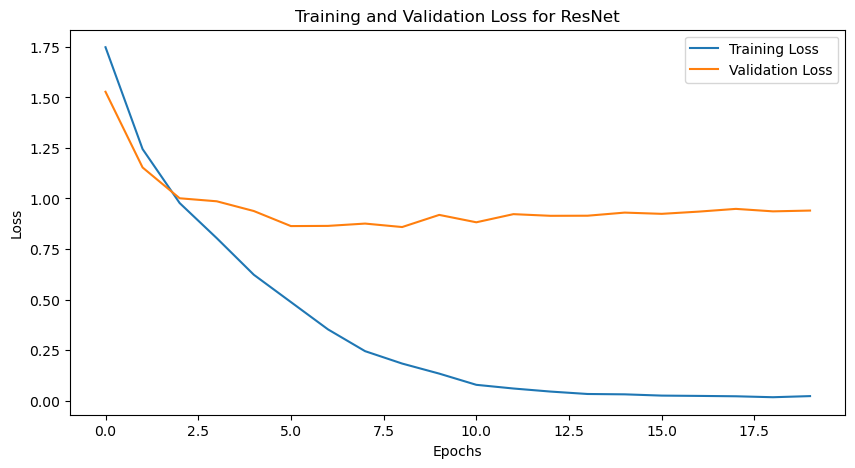

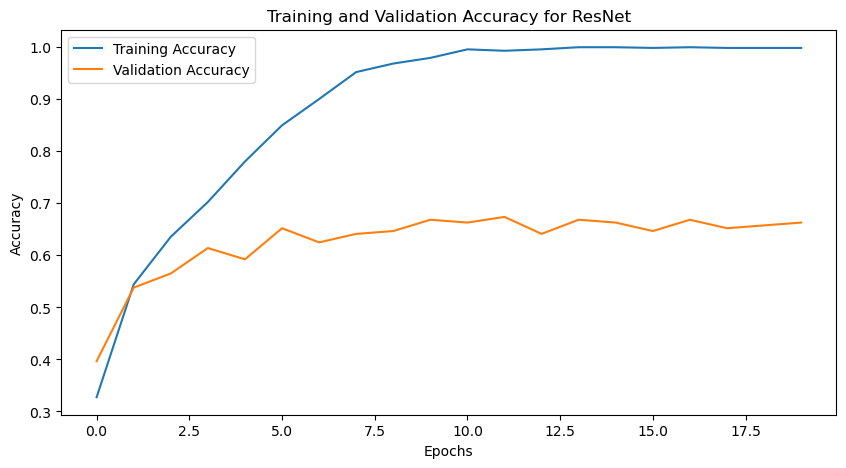

In [7]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy


plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet')
plt.legend()
plt.show()

Accuracy: 0.6630
Precision: 0.7099
Recall: 0.6630
F1-Score: 0.6706
MCC: 0.6017


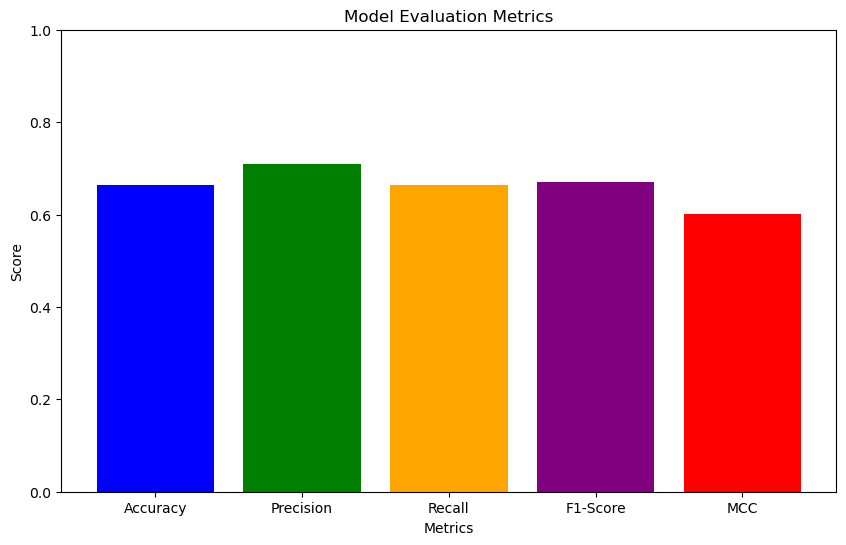

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
import matplotlib.pyplot as plt

# Initialize metrics for evaluation
accuracies = []
precisions = []
recalls = []
f1_scores = []
mcc_scores = []

# Evaluation Phase
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mcc = matthews_corrcoef(all_labels, all_preds)

# Store Metrics
accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
mcc_scores.append(mcc)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

# Bar Graph Visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']
values = [accuracy, precision, recall, f1, mcc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.ylim(0, 1)  # Since metrics are between 0 and 1
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.show()

VGG Model

In [10]:
import torch
import torch.nn as nn
from torchvision import models

class CustomVGG(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG, self).__init__()
        self.model = models.vgg16(pretrained=True)  # You can choose vgg11, vgg13, etc.
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)  # Modify final FC layer
        self.model.num_classes = num_classes

    def forward(self, x):
        return self.model(x)  

# Instantiate model, optimizer, and loss function
num_classes = 7  # Replace with your number of classes
VGGmodel = CustomVGG(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGGmodel.to(device)


C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomVGG(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [12]:
import matplotlib.pyplot as plt

# Variables to store metrics
VGGtrain_losses = []
VGGval_losses = []
VGGtrain_accuracies = []
VGGval_accuracies = []

for epoch in range(num_epochs):
    VGGmodel.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = VGGmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    VGGtrain_losses.append(train_loss / len(train_loader.dataset))
    VGGtrain_accuracies.append(correct_train / total_train)

    VGGmodel.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = VGGmodel(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    VGGval_losses.append(val_loss / len(val_loader.dataset))
    VGGval_accuracies.append(correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {VGGtrain_losses[-1]:.4f}, Train Acc: {VGGtrain_accuracies[-1]:.4f}")
    print(f"Val Loss: {VGGval_losses[-1]:.4f}, Val Acc: {VGGval_accuracies[-1]:.4f}")


Epoch 1/20:
Train Loss: 2.0192, Train Acc: 0.1132
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 2/20:
Train Loss: 1.9862, Train Acc: 0.1405
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 3/20:
Train Loss: 2.0005, Train Acc: 0.1432
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 4/20:
Train Loss: 2.0118, Train Acc: 0.1296
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 5/20:
Train Loss: 2.0125, Train Acc: 0.1282
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 6/20:
Train Loss: 2.0131, Train Acc: 0.1487
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 7/20:
Train Loss: 2.0153, Train Acc: 0.1201
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 8/20:
Train Loss: 2.0278, Train Acc: 0.1146
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 9/20:
Train Loss: 2.0378, Train Acc: 0.1160
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 10/20:
Train Loss: 1.9975, Train Acc: 0.1378
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 11/20:
Train Loss: 2.0250, Train Acc: 0.1337
Val Loss: 1.9891, Val Acc: 0.0924
Epoch 12/20:
Train Loss: 1.9998, Train Acc: 0.1392
Val Loss: 1.9891, Val A

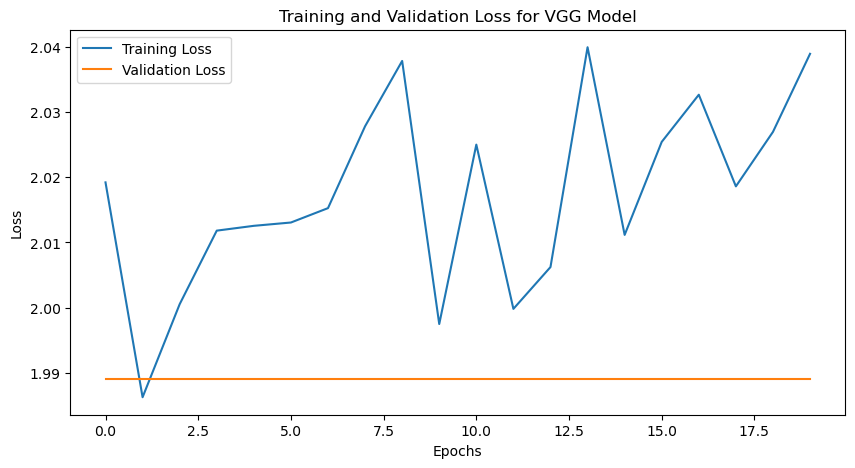

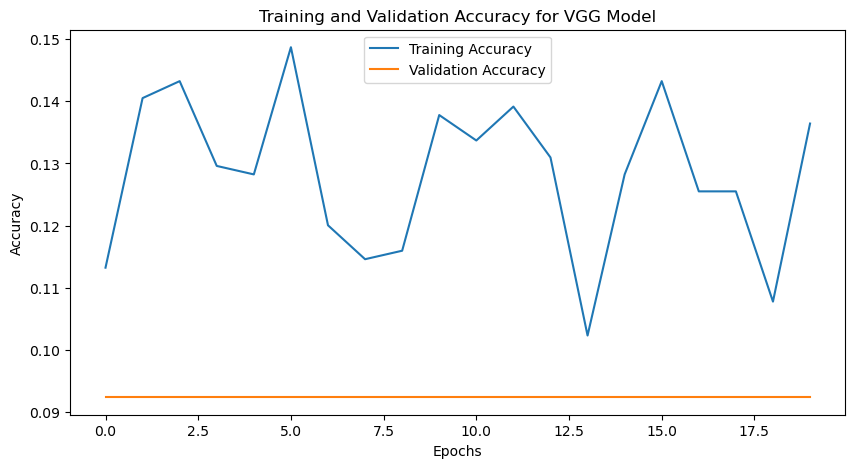

In [14]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(VGGtrain_losses, label='Training Loss')
plt.plot(VGGval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG Model')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(VGGtrain_accuracies, label='Training Accuracy')
plt.plot(VGGval_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG Model')
plt.legend()
plt.show()


Model Evaluation Metrics:
Accuracy  : 0.0924
Precision : 0.2198
Recall    : 0.0924
F1-Score  : 0.0969
MCC       : -0.0421


C:\Users\CVR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


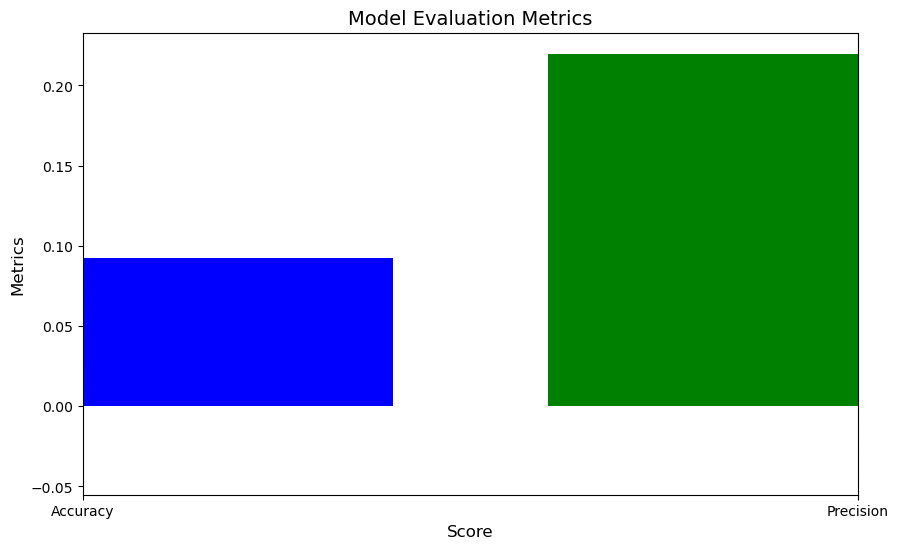

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
import matplotlib.pyplot as plt


# Variables to store metrics
VGGtrain_losses = []
VGGval_losses = []
VGGtrain_accuracies = []
VGGval_accuracies = []


# Initialize metrics for evaluation
accuracies = []
precisions = []
recalls = []
f1_scores = []
mcc_scores = []

# Evaluation Phase
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mcc = matthews_corrcoef(all_labels, all_preds)

# Store Metrics
accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
mcc_scores.append(mcc)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

# Bar Graph Visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']
values = [accuracy, precision, recall, f1, mcc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.ylim(0, 1)  # Since metrics are between 0 and 1
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.show()